<a href="https://colab.research.google.com/github/AntJuLRa/ANLP-project-/blob/main/rabe_anlp_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANLP 2020 - Assignment 3

*Anton Rabe, 810313* 

<div class="alert alert-block alert-danger">Due: Wednesday, January 20, 2021, 23:59</div>

<div class="alert alert-block alert-info">

**NOTE**
<br>

Please first fill in your name and id number at the top of the assignment, and **rename** the assignment file to **yourlastname-anlp-3.ipynb**<br><br>
Problems and questions are given in blue boxes like this one. All grey and white boxes marked by the comment "#student solution/discussion here" must be filled by you (they either require code or a (brief!) discussion). <br><br>
Please hand in your assignment by the deadline via Moodle. In case of questions, you can contact the TAs and the instructors via the usual channels.

</div>

<div class="alert alert-block alert-info">
    
In this assignment, you will implement an LSTM model and train it to generate text, one character at a time. (So note: We're asking you to create a character-level model; in the lectures, we've so far only seen word-level models. Think about what the difference is, and what its practical consequences are.)

For training, we prepared two text files (train and test) containing passages from Charles Dickens' novels (dickens_train.txt, dickens_test.txt).

You should use the PyTorch machine learning library to implement this exercise.

- Instructions to install PyTorch can be found here: <http://pytorch.org/>
- The introductory tutorial we prepared for PyTorch is attached to the assignment: pytorch_lecture_2019.ipynb
- Some PyTorch examples for an in depth overview: <https://github.com/jcjohnson/pytorch-examples>
- Another common quickstart tutorial is this [PyTorch 60 Minutes Blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)

(But don't get carried away: For this assignment, you mostly need the very straightforward elements from the `nn` module in PyTorch that implement the layers that you've learned about, such as RNNS, LSTMs, embeddings.)

This assignment is designed to be runnable on a decent CPU. With 2 layers LSTM and hidden size of 128, it takes ~20 minutes to train while with hidden size of 512, it takes ~2 hours. Please take this into consideration while doing this assignment. 

Alternatively you can also use Google Colab <https://colab.research.google.com/> by uploading your notebook there, which gives you access to a GPU. (Check that you are indeed using the GPU, via `print(torch.cuda.is_available()`.) However, please keep mind as there is limitation for the free edition (i.e. 'maximum lifetime' of 12 hours).


The goal of this assignment is to get you to specify a simple network, and play around with its hyperparameters to explore how they affect the output. This is why we're providing you with a lot of code, to ensure that the basic housekeeping is taken care of.

</div>

# Prepare data

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package (which you can install via `pip` or `conda`). (What do you think is the use of this step?)

In [ ]:
!pip install unidecode
import unidecode
import string
import random
import re
import numpy as np

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('dickens_train.txt').read())
file_len = len(file)
print('file_len =', file_len)

file_len = 1136673


To make inputs out of this big string of data, we will be splitting it into chunks.

In [ ]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len -1) 
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

ike Jerry's voice, if it is Jerry," growled the guard
to himself. "He's hoarser than suits me, is Jerry.")

  "Yes, Mr. Lorry."

  "What is the matter?"

  "A despatch sent after you from over yonder. 


# Build the Model (30 points)

<div class="alert alert-block alert-info">

The model that you are asked to build will take as input characters up to step $t-1$ and is expected to produce a distribution over characters at step $t$ (which can then be used to sample one character from that distribution). 

There are three layers: one layer that maps the input character into its embedding, one LSTM layer (which may itself have multiple layers) that operates on that embedding and a hidden and cell state, and a decoder layer that outputs the probability distribution.

The beauty of frameworks such as PyTorch is that you can express this pretty directly in code, adding (pre-defined) layers to your network.
</div>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as fnc
torch.manual_seed(42)


class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, embedding_dim=6):
        super(LSTM, self).__init__()
        """Think about which (hyper-)parameters your model needs; i.e., parameters that determine the
        exact shape (as opposed to the architecture) of the model. There's an embedding layer, which needs 
        to know how many elements it needs to embed, and into vectors of what size. There's a recurrent layer,
        which needs to know the size of its input (coming from the embedding layer). PyTorch also makes
        it easy to create a stack of such layers in one command; the size of the stack can be given
        here. Finally, the output of the recurrent layer(s) needs to be projected again into a vector
        of a specified size."""
        self.i_dim= input_dim
        self.e_dim= embedding_dim
        self.h_dim= hidden_dim
        self.o_dim= output_dim
        self.n_layers= num_layers
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(input_size=self.e_dim, hidden_size=self.h_dim, num_layers=self.n_layers)
        self.out = nn.Linear(self.h_dim,self.o_dim)
        
    
    def forward(self, inp, hidden_cell):
        """Your implementation should accept input character, hidden and cell state,
        and output the next character distribution and the updated hidden and cell state."""
        embedded = self.embedding(inp)
        lstm_out, hidden = self.lstm(embedded.view(1,1,-1), hidden_cell)
        res = self.out(lstm_out.view(1, -1))
        res = fnc.log_softmax(res, dim=1)
        
        return res, hidden 
        

    def init_hidden(self):
        """Finally, you need to initialize the (actual) parameters of the model (the weight
        tensors) with the correct shapes.""" 
        hidden=torch.zeros(self.n_layers,1,self.h_dim)
        cell = torch.zeros(self.n_layers,1,self.h_dim)
        return hidden, cell

# Inputs and Targets

Each chunk of the training data needs to be turned into a sequence of numbers (of the lookups), specifically a `LongTensor` (used for integer values). This is done by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [ ]:
from torch.autograd import Variable 

# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


Finally we can assemble a pair of input and target tensors for training, from a random chunk. The input will be all characters *up to the last*, and the target will be all characters *from the first*. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

In [ ]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

In [ ]:
#rts = random_training_set()
#rts

Play around with these functions to understand what they do.

# Generating

We also provide a generator function that shows you how you can sample from your model (and how we expect the interface to work). 

`decoder` is your model that is passed into the function. To start generating, we pass a priming string to start building up the hidden state, from which we then generate one character at a time. To generate strings with the network, we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. 

In [ ]:
def generate(decoder, prime_str='A', predict_len=100, temperature=0.8):
    hidden, cell = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, (hidden, cell) = decoder(prime_input[p], (hidden, cell)) 
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, (hidden, cell) = decoder(inp, (hidden, cell))
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

# Training

A helper to print the amount of time passed:

In [ ]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

The main training function

In [ ]:
def train(decoder, decoder_optimizer, inp, target):
    hidden, cell = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, (hidden, cell) = decoder(inp[c], (hidden, cell))
        loss += criterion(output, target[c].view(1))

    loss.backward()
    decoder_optimizer.step()

    return loss.item() /chunk_len

Then we define the training parameters, instantiate the model, and start training:

In [ ]:
n_epochs = 3000
print_every = 100
plot_every = 10
hidden_size = 128
n_layers = 2

lr = 0.005
decoder = LSTM(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs+1):
    loss = train(decoder, decoder_optimizer, *random_training_set())
    loss_avg += loss

    if epoch % print_every == 0:
        print('[{} ({} {}%) {:.4f}]'.format(time_since(start), epoch, epoch/n_epochs * 100, loss))
        print(generate(decoder, 'A', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg/ plot_every)
        loss_avg = 0

 28s (100 3.3333333333333335%) 3.0695]
Ayt e dow,loiee ch  eobfmiohn   h sshid ewoof,o naned  sogdf,suh ethhi s odh eoskr m tlhd
 a Seroluro 

 0s (200 6.666666666666667%) 2.8204]
A, htis boo uiu. hs or haa thx ah hy. soft eond osn pes 
uaho
snrkre moeeee. s twaa
loa a, ehae pca n 

 28s (300 10.0%) 2.6766]
Aisyi ar mor mh'nd

ier ho of he thel
an tee' Bhlee fnee nn s thatre tuibeu has Mon., of and poiiad w 

 56s (400 13.333333333333334%) 2.4650]
Ast ber  hang shate to wer hMunt ind hatenty the mouy in bhith andeny and mek Hind the tad wuhed f; b 

 24s (500 16.666666666666664%) 2.3740]
Ag in of nan savt pomd
as if ood and Seageittib
is sopt
hat fher ny ile heobawede pattand ftonhi

Mr  

 52s (600 20.0%) 2.1629]
An besband; the tucing in batens, whecn the fores, and houed at, 

'is wemkery me
enteranded a in sul 

 20s (700 23.333333333333332%) 2.3123]
Ad nome reavs to brat lich wackincher, the 
ullere besenting a cyoutulpund home, houn! and palled sar 

 48s (800 26.666666666666668%

Explain in your words what is going on here. What do these parameters do, what is happening inside the training loop? (**bonus question**)
**Answer:**   
*The hyperparameters of the model and parameters defining learning rate and number of epochs are declared. The model and an optimizer are initiallized. For each loop step(epoch) the average loss over a random chunk from the training set is computed and the weights of the model are updated via backward pass using the optimizer.  
Every ten (plot_every) loop steps the average loss in the last ten steps is saved to a list (all_losses). Every 100 (print_every) loop steps the is used to generate a string with 100 characters starting with "A", which is then printed along with the current number of epochs, the time passed, and the % of epochs completed.*

# Hyperparameter tuning (30 points)

<div class="alert alert-block alert-info">

Building neural networks is to some extent more an art than a science. As we have seen above, there are several hyperparameters (i.e., parameters that are not optimized during learning, but that determine the shape of the network), and their setting influences the performance. In this problem, you're asked to *tune* these hyperparameters (that is, optimize heuristically, rather than using for example stochastic gradient descent). You can try to do this systematically (how?), or just in general explore what changing the parameter does to the performance. (Keep in mind the time it takes to train again for each setting.)

To do so, you need a target. We'll use bits per character (BPC) over the entire the test set `dickens_test.txt`. 
BPC is defined as the empirical estimate of the cross-entropy between the target distribution and the model output in base 2. 

(Hint1: You can adapt the formula for word-level cross-entropy given in your text book (chapter 9) to character-level as $-\frac{1}{T}*\sum_{i=1}^{T}log{_2}{m(x_t)}$ where T is the length of input string and $x_t$ is the true character in input string at location $t$.)

(Hint2: Tune one parameter at a time) 

(Hint3: Keep a log of your experiments for "parameters used --> minimum loss value")

</div>

**Answer:**  *We can tune the following Parameters:  
The size of the hidden layers, the embedding dimension, and the number of recurrent layers.  
If the hidden layer or the embedding dimension are too small, the network will not be able to represent single characters and structures as well (different things would be representet as closer together) and it will ultimately not be able to perform better than a certain upper bound. If the hidden layers are very large, the time needed for training will increase, so beyond a certain point the increase in performance won't be worth it. The same is true for the number of hidden layers. Adding more hidden layers will drastically increase training time but can also increase performance in a way a simple increase in layer size can not. A model with more layers should also need more epochs to reach a certain loss and BPC but can ultimately lead to lower loss and BPC.*  

*There are several approaches to systematically explore the hyperparameter space. The most straight forward approach is creating a grid of points with n<sub>x</sub> different values from each of the x dimensions representing a hyperparameter of the model. This leaves us with around n<sup>x</sup> cases to test. And we need to be sure about the order of magnitude of our parameters. This can become impractical for large amounts of steps and parameters. If you can assume independence of the different parameters i.e their effects on the loss simply add up, you can reduce the number of tests to n times x by simply testing one parameter at a time and keeping the others constant. This is what I will do for embedding-dimension, hidden layer-size andthe number of recurrent layers.  
Athor approach would be to randomly sample a points in parameter space using different distributions. In more advanced approaches this can be combined with bayesian optimization or evolutionary algorithms but that is beyond the scope of this assignment.*



In [ ]:
#reading and setting up the test set.
test_file = unidecode.unidecode(open('dickens_test.txt').read())
test_set = char_tensor(test_file)

In [ ]:
#A method returning BPC-measure of a trained network on a test set.
def BPC(trained_decoder, test_set):
  (hidden, cell) = trained_decoder.init_hidden()
  inp = test_set[1]
  res = 0
  for x in test_set[2:]:
    output, (hidden, cell) = trained_decoder(inp, (hidden, cell))
    try:
      res= res + math.log2(math.exp(output[:,x]))
    except KeyError:
      pass
    inp = x

  return -res/(len(test_set)-1)

In [ ]:
#A method based on the code given above that trains a model an returns the plotted losses and the time needed.
def fully_train(network, lr=0.005, n_epochs=3000, print_generate=True, print_every=500, plot_every=10):
  decoder_optimizer = torch.optim.Adam(network.parameters(), lr=lr)
  start = time.time()
  all_losses = []
  loss_avg = 0

  for epoch in range(1, n_epochs+1):
      loss = train(network, decoder_optimizer, *random_training_set())
      loss_avg += loss

      if epoch % print_every == 0 and print_generate:
          print('[{} ({} {}%) {:.4f}]'.format(time_since(start), epoch, epoch/n_epochs * 100, loss))
          print(generate(network, 'A', 100), '\n')

      if epoch % plot_every == 0:
          all_losses.append(loss_avg/ plot_every)
          loss_avg = 0

  return all_losses, time_since(start)

#The loss criterion needed for the train method.
criterion = nn.CrossEntropyLoss() 

In [ ]:
import pandas as pd

#Experimenting with different numbers of layers.
lyr_losses = pd.DataFrame()
lyr_bpc = pd.DataFrame()
lyr_time = pd.DataFrame()
network_list = []
n_layers = [1,2,3,4]
for x in n_layers:
  dec= LSTM(n_characters, 128, n_characters, x, embedding_dim=12)
  dec_losses, dec_time = fully_train(dec, n_epochs=3000, print_every=3000)
  network_list.append(dec)
  lyr_time[str(x)] = pd.Series(dec_time)
  lyr_losses[str(x)] = pd.Series(dec_losses)
  lyr_bpc[str(x)] = pd.Series(BPC(dec, test_set))

 56s (3000 100.0%) 1.6715]
A can up you genes sort to acquiated at and upon the
Jand into me, to the showes of this caried mind  

 32s (3000 100.0%) 1.7149]
At Ml. He me and I with on come when a litted forts her he of a boys a read, and but the 
knon his in 

 29s (3000 100.0%) 1.8565]
Agent in he do arry.  Herent an fin the said and more of him should when her very hand awould of pret 

 54s (3000 100.0%) 2.4402]
Ats, ler, a thund the ofqer le
yoade Tad hiph of en as shoos,

yharginge eppeinl las onfer ar C
ofes  



In [ ]:
#see the correct epoch count on plots
lyr_losses.index = lyr_losses.index*10

In [ ]:
#converting the time output of the training method back to floats for plotting
def reconvert_time(timestring):
    timestring= timestring[:-1]
    seconds = float(timestring[-2:])
    
    rest= timestring[:-2]
    minutes= float(rest.split("m")[0])

    return minutes + 0.0166*seconds

In [ ]:
for x in lyr_time.columns:
  lyr_time[x] = reconvert_time(lyr_time[x][0])

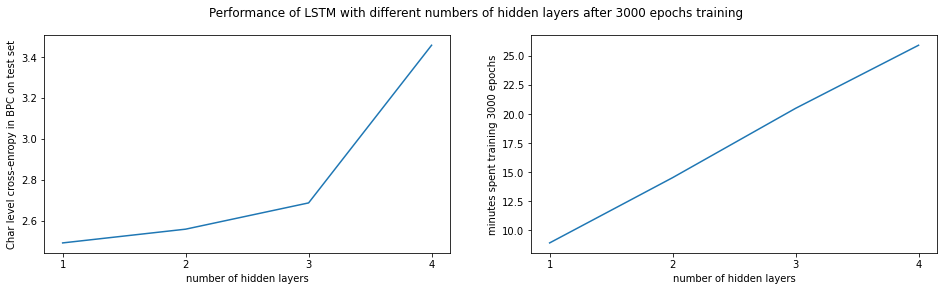

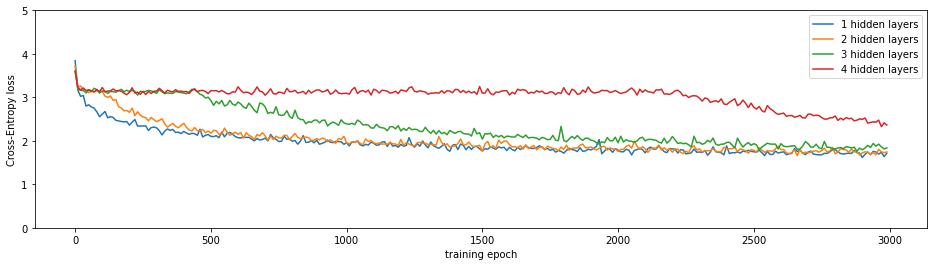

In [ ]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16, 4))
fig.suptitle('Performance of LSTM with different numbers of hidden layers after 3000 epochs training')
ax1.plot(lyr_bpc.iloc[0])
ax1.set_xlabel("number of hidden layers")
ax1.set_ylabel("Char level cross-enropy in BPC on test set")
ax2.plot(lyr_time.iloc[0])
ax2.set_xlabel("number of hidden layers")
ax2.set_ylabel("minutes spent training 3000 epochs")
plt.show()

fig, ax = plt.subplots(figsize=(16, 4))
for column in lyr_losses:
  ax.plot(lyr_losses[column], label=column+ " hidden layers")

ax.legend()
ax.set_ylim([0, 5]) 
ax.set_xlabel("training epoch")
ax.set_ylabel("Cross-Entropy loss")
plt.show()

As expected the number of hidden layers increases the time needed for training linearly. Surprisingly models with more hidden seem to have a worse bpc-measure over the test set. 
My guess is that those bigger models simply need more epochs to get to the same point as smaller models but can ultimately outperform them. Plotting the losses during training seems to support at least the first claim.

In [ ]:
#Experimenting with different embedding dimensions.
emb_losses = pd.DataFrame()
emb_bpc = pd.DataFrame()
emb_time = pd.DataFrame()
emb_network_list = []
embs = [3,6,9,12,15,18]
for x in embs:
  dec= LSTM(n_characters, 128, n_characters, 2, embedding_dim=x)
  dec_losses, dec_time = fully_train(dec, n_epochs=2000, print_every=2000)
  emb_network_list.append(dec)
  emb_time[str(x)] = pd.Series(dec_time)
  emb_losses[str(x)] = pd.Series(dec_losses)
  emb_bpc[str(x)] = pd.Series(BPC(dec, test_set))

 54s (2000 100.0%) 1.9043]
Aerseldery have it he hand have dime have I
and preting at a as cardary said in the it me hith be han 

 50s (2000 100.0%) 1.8296]
AEd yournessed to
the
otcenbed for I the play of have it say knowe the more 
sid to serlimed she nigh 

 48s (2000 100.0%) 1.9094]
And was hould unded he wame.  The pristing appered him, that Mrs. CATDEU?  Hearkle
of comper we head  

 45s (2000 100.0%) 1.7303]
Ay, and wrich in a hard - We coll stispalent, strostly the were under the letty who masting, whim Gar 

 0s (2000 100.0%) 1.8892]
Athed up of but but
Didfure of the gromsson post to it became off aspart to had was a shere hore was  

 46s (2000 100.0%) 1.7870]
A pornuired, whide you mean, and Stangited to was exill hand then for set and thement
her mud.  It ha 



In [ ]:
emb_losses.index = emb_losses.index*10
for x in emb_time.columns:
  emb_time[x] = reconvert_time(emb_time[x][0])

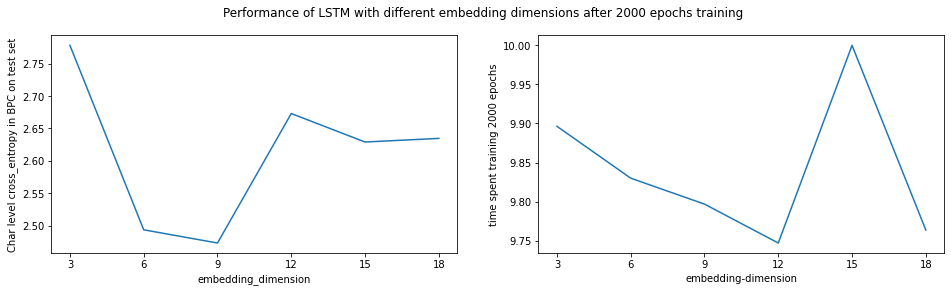

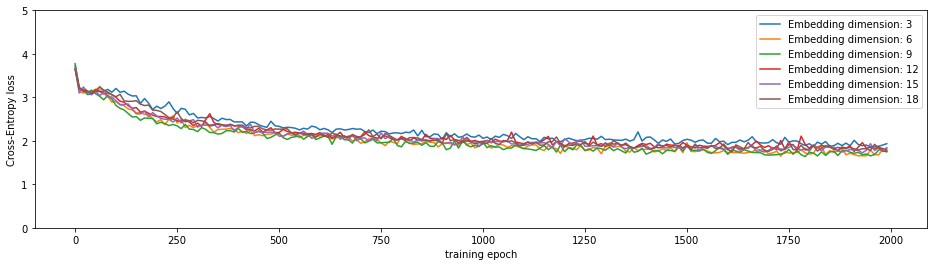

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16, 4))
fig.suptitle('Performance of LSTM with different embedding dimensions after 2000 epochs training')
ax1.plot(emb_bpc.iloc[0])
ax1.set_xlabel("embedding_dimension")
ax1.set_ylabel("Char level cross_entropy in BPC on test set")
ax2.plot(emb_time.iloc[0])
ax2.set_xlabel("embedding-dimension")
ax2.set_ylabel("time spent training 2000 epochs")
plt.show()

fig, ax = plt.subplots(figsize=(16, 4))
for column in emb_losses:
  ax.plot(emb_losses[column], label="Embedding dimension: " + column)

ax.legend()
ax.set_ylim([0, 5]) 
ax.set_xlabel("training epoch")
ax.set_ylabel("Cross-Entropy loss")
plt.show()

Models with different embedding dimensions show no significant differences in training duration and loss curve. An embedding dimension between 6-9 seems to lead to the lowest cross-entropy over the test set.

In [ ]:
#Experimenting with different hidden layer dimensions.
hid_losses = pd.DataFrame()
hid_bpc = pd.DataFrame()
hid_time = pd.DataFrame()
hid_network_list = []
hid = [32,64,128,256]
for x in hid:
  dec= LSTM(n_characters, x, n_characters, 2, embedding_dim=8)
  dec_losses, dec_time = fully_train(dec, n_epochs=2000, print_every=2000)
  hid_network_list.append(dec)
  hid_time[str(x)] = pd.Series(dec_time)
  hid_losses[str(x)] = pd.Series(dec_losses)
  hid_bpc[str(x)] = pd.Series(BPC(dec, test_set))

 47s (2000 100.0%) 2.1628]
Ate hapf was and lapter casitipent
at being the taloors of onser a door thif 'round loled of with a m 

 14s (2000 100.0%) 1.9410]
And - I me bestise seen is and acless in Me.  Then yeart, the binding he me his will
me with sitty, I 

 46s (2000 100.0%) 1.7371]
A long and and the
cartal any she hear!  Whished on young her looked she wike whink, the was 
a ammup 

 43s (2000 100.0%) 1.7815]
Adention, the colour scriage the fell antitions and looked and the partimy of that I spule of the spe 



In [ ]:
#prepare time and epochs scale for plotting
hid_losses.index = hid_losses.index*10
for x in hid_time.columns:
  hid_time[x] = reconvert_time(hid_time[x][0])

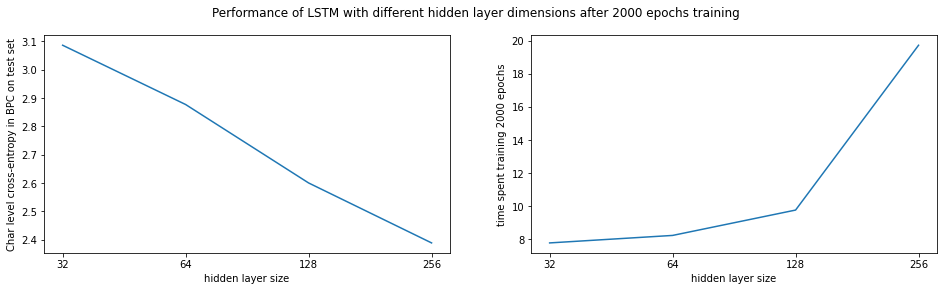

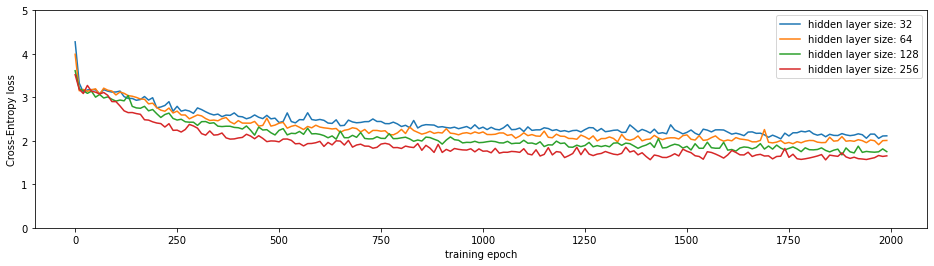

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16, 4))
fig.suptitle('Performance of LSTM with different hidden layer dimensions after 2000 epochs training')
ax1.plot(hid_bpc.iloc[0])
ax1.set_xlabel("hidden layer size")
ax1.set_ylabel("Char level cross-entropy in BPC on test set")
ax2.plot(hid_time.iloc[0])
ax2.set_xlabel("hidden layer size")
ax2.set_ylabel("time spent training 2000 epochs")
plt.show()

fig, ax = plt.subplots(figsize=(16, 4))
for column in hid_losses:
  ax.plot(hid_losses[column], label="hidden layer size: " + column)

ax.legend()
ax.set_ylim([0, 5]) 
ax.set_xlabel("training epoch")
ax.set_ylabel("Cross-Entropy loss")
plt.show()

An increase in hidden layer size leads to a decrease in cross-entropy over the test set and an increase in time consumption. In theory the time needed should grow with n<sup>l</sup> with l being the number of hidden layers.

# Plotting the Training Losses (20 points)


<div class="alert alert-block alert-info">
An important aspect of deep network training task is visualization. Visualizing the training loss values would be helpful for debugging the system. For instance, at extremes, a learning rate that is too large will result in weight updates that will be too large and the performance of the model (such as its loss on the training dataset) will oscillate over training epochs. You would set the learning rate which do not cause oscillation with the help of visual charts.
    
In this exercise, we ask you to add the loss charts of experiments with different learning rates on the same graph and plot the graph. Add an entry for each experiment to the legend of the graph. If there is more than 10 experiments, use more than 1 chart (up to 10 experiments for each chart).

</div>

In [ ]:
#I start out with training with learning rates of different orders of magnitude
import pandas as pd
lr_losses = pd.DataFrame()
lrs = [0.05,0.005,0.0005,0.00005]
for x in lrs:
  dec= LSTM(n_characters, 128, n_characters, 2, embedding_dim=12)
  dec_losses, _ = fully_train(dec, lr=x, n_epochs=2000, print_every=2000)
  lr_losses[str(x)] = pd.Series(dec_losses)

 22s (2000 100.0%) 2.4196]
Aephas as shreaonwing frerer sattingacs.    Braandwke gelifket ansed ath, I an atone satts he woumeld 

 18s (2000 100.0%) 1.8944]
Ariguf of I had witty fould and a you forchaf, and the dadlance, had her her wither we good and must  

 17s (2000 100.0%) 2.4037]
AE irs and
fing biney a far
thed! 
wat wottang statt menthinse the sorras
oware

Womlout igoo sor th  

 17s (2000 100.0%) 3.0103]
A_Tchio eni
  seetii tmf aI  hMbemd emymt luhtrctrdo oetwen  eae oen oao el otrs no saetsutekis,aes 
 



In [ ]:
#A learning rate of 0.5 would sometimes lead to complications during calculation which is why I calculate it separatetly.
dec50= LSTM(n_characters, 128, n_characters, 2, embedding_dim=12)
dec50_losses, _ = fully_train(dec, lr=0.5, n_epochs=2000, print_every=2000)
lr_losses["0.5"] = pd.Series(dec50_losses)

 8s (2000 100.0%) 3.2821]
A mexpe t se  biber bilt, M the rfe fatmlt Mrh. omer be for fe momtesllltrs be se  be besp be wofe th 



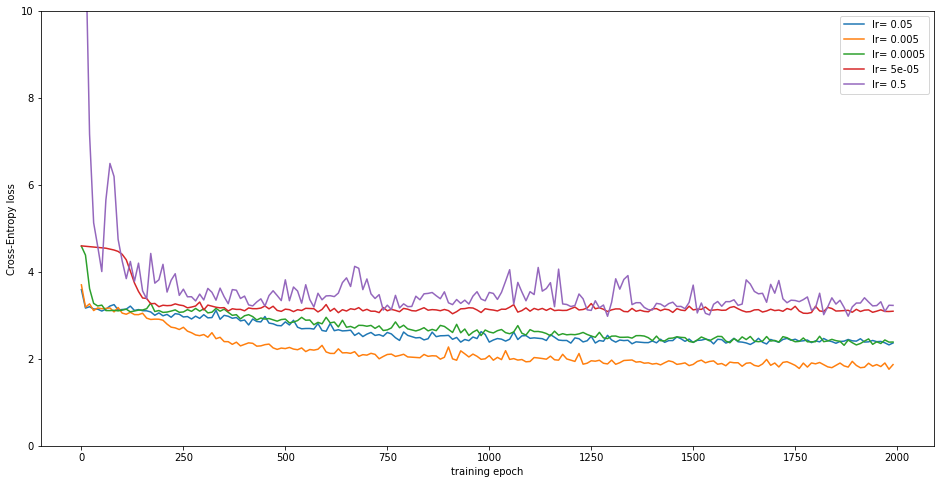

In [ ]:
#plotting the training losses.
fig, ax = plt.subplots(figsize=(16, 8))

lr_losses.index = lr_losses.index*10
for column in lr_losses:
  ax.plot(lr_losses[column], label="lr= " + column)

ax.legend()
ax.set_ylim([0, 10]) 
ax.set_xlabel("training epoch")
ax.set_ylabel("Cross-Entropy loss")
plt.show()

In [ ]:
#I will continue with trying some lrs around the best lr so far (0.005)
#To save time I limit the training to 1500 epochs.
ft_losses = pd.DataFrame()
lrs = [0.001,0.003,0.005,0.007,0.009,0.012]
for x in lrs:
  dec= LSTM(n_characters, 128, n_characters, 2, embedding_dim=12)
  dec_losses, _ = fully_train(dec, lr=x, n_epochs=1500, print_every=1500)
  ft_losses[str(x)] = pd.Series(dec_losses)

 55s (1500 100.0%) 2.2322]
Atn on thy afd befon his hat the when the im ses lack the  foth or ther as a emlerith on to I he thac 

 54s (1500 100.0%) 2.2678]
Acuuld 
as, and ip she glatty of sime to as of hive sarder a sar of the wouch fearge
aster the dissa  

 52s (1500 100.0%) 1.8691]
Anfed - sine; and that at him I that I loother for the gat my may the lade bol that I that I have had 

 57s (1500 100.0%) 1.9383]
A look not, if a not the werrouch dud as my bearing hild withould at is see kised!"  That without was 

 58s (1500 100.0%) 1.7062]
Amply to see have of the soning shight and viad-digater smapre frions too meer of the yays, Mr. Shepo 

 57s (1500 100.0%) 1.6617]
Ad - a stake to hall-cained as a looken young his sir. 'Housed, and down outs, I Tain, bropporning an 



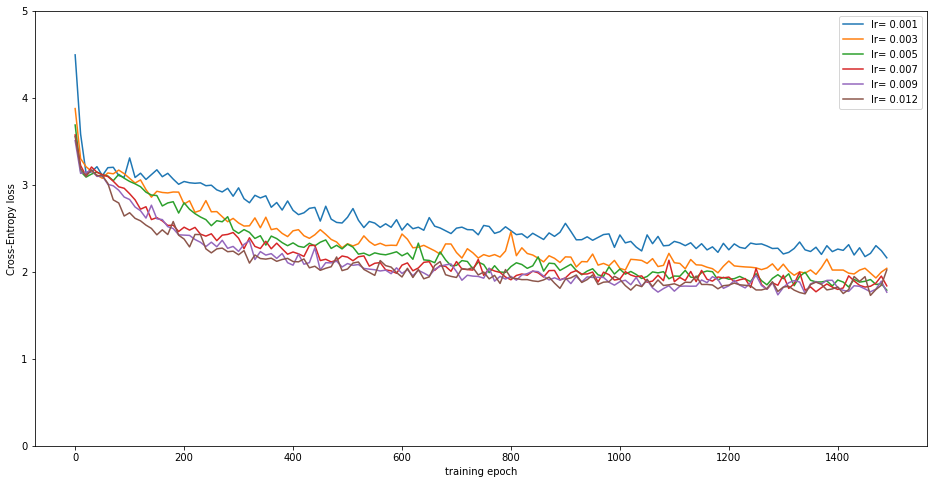

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))

ft_losses.index = ft_losses.index*10
for column in ft_losses:
  ax.plot(ft_losses[column], label="lr= " + column)
  
ax.legend()
ax.set_ylim([0, 5]) 
ax.set_xlabel("training epoch")
ax.set_ylabel("Cross-Entropy loss")
plt.show()

# Generating at different "temperatures" (20 points)

<div class="alert alert-block alert-info">

In the `generate` function above, every time a prediction is made, the outputs are divided by the "temperature" argument passed. 

Generate strings by using different `temperature` values and evaluate the results qualitatively. Create chunks from the test set (200 character length as above) and take the first 10 characters of a randomly chosen chunk as a priming string.
What you observe in the output when you increase the `temperature` values? **In your understanding**, why does changing the temperature affect the output as the way you observed?
</div>

In [ ]:
def random_test_chunk():
    start_index = random.randint(0, len(test_file) - chunk_len -1) 
    end_index = start_index + chunk_len + 1
    return test_file[start_index:end_index]

chunk =random_test_chunk()
first_ten= chunk[:10]
model = hid_network_list[3]

In [ ]:
print("True string: ","\n\n",chunk, "\n\n")

print("Generation at temperature=8: ","\n\n", generate(model, first_ten, 200, temperature=8), "\n\n")
print("Generation at temperature=3: ", "\n\n",generate(model, first_ten, 200, temperature=3), "\n\n")
print("Generation at temperature=1.5: ", "\n\n",generate(model, first_ten, 200, temperature=1.5), "\n\n")
print("Generation at temperature=1: ", "\n\n",generate(model, first_ten, 200, temperature=1), "\n\n")
print("Generation at temperature=0.8: ", "\n\n",generate(model, first_ten, 200, temperature=0.8), "\n\n")
print("Generation at temperature=0.3: ", "\n\n",generate(model, first_ten, 200, temperature=0.3), "\n\n")
print("Generation at temperature=0.08: ", "\n\n",generate(model, first_ten, 200, temperature=0.08), "\n\n")
print("Generation at temperature=0.03: ", "\n\n",generate(model, first_ten, 200, temperature=0.03), "\n\n")

True string:  

 re the fire, 'when are you going over to
Canterbury?'

'I shall get a horse, and ride over tomorrow morning, aunt, unless
you will go with me?'

'No!' said my aunt, in her short abrupt way.  'I mean to 


Generation at temperature=8:  

 re the firptIr9H:F 'lOYPrRYi)IBo?>f7}0m
y%kX"benyr,fb9llNUHJ_-
jcCp)a#Pum
aF?joJ!dt'(w.
TNuEjafofk _TIq?>ahZ)ffZnJT#U4bs,)S;{q'u2t2j.1M?aiH"I8.G=UUC .KT-AnF i*f
dr4T"&hs=2lu)joy3`pghQn?"nK.abQ_s W/*AU" 


Generation at temperature=3:  

 re the firrctSyav
andot?'

"attC'pPw
Boo;. O CWutge
ssuanS, *oluut Dcqav%ihng,-I owneffr;uc1aned howaceibeck'

-NOsind SsOUWsyrh,! TexAr,
MYELWy.
MDxeNLE: 


Generation at temperature=1.5:  

 re the firgmeny.  Then CPiles stuage 'wrewgops wells life of it.  They cax was it, I veastiaring on undersonbs ic alocs C-then Qever
Defice costiinseomn; an kept much terv, fournox him."
sqr|ers: ,oud vicioa! t 


Generation at temperature=1:  

 re the fire; for which in, and torperkien to ve.  'Not, toge of
the

**Answer:**  
*At high temperatures (~above 1.5) no cohesive words are generated.  
Choosing a temperature of 8 leads to pretty much random sequences of characters as the absolute differences between the probabilities assigned to the different caracters are getting very small in proportion due to the large denominator.
At temperatures closer to one some sequences appear not to be entirey random any more. At a temperature of 1.5 spaces and punctuation appear at the right place and "words" have the right length. Only very common sequences from english can be recognized.  
A temperatuer value of 1 leads to the output directly resembling samples from the unaltered distribution returned by the output layer of the neural network. A few more words can be recognized and line breaks are now at similar positions as in the training data.  
For temperatures <1 the randomness boosting effect I explained above is reversed and the differences between high and low probabilities increase. This leads to the generation process favoring more common words. This can also be seen when looking at the examples above. At a temperature of 0.8 the model generates the more common continuation "first" from "fir" compared to "fire" at a temperature of 1.  
At a temperature of 0.8 most words resemble proper english words as more common follow-up chars are now boosted in probability.  
At 0.3 this number is even higher.  
Beginning at temperature values of 0.3 and below, the model choses almost always exclusively the most likely continuations at each step. This leads to the output being a loop of one appearently very common sequence of words with little exceptions at 0.08 and none at 0.03.*

In [ ]:
import dill as dill
dill.dump_session("anlp3.db")

(If you still have energy / time left once you've reached this place here, try using other datasets (other texts; other types of text, like for example the Linux source code), other layers (e.g., a GRU instead of LSTM), etc. etc..) (**bonus question**)